# Modelo de detección de emociones en perros

Conectar con Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importar librerías

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix

Obtener las imágenes

In [ ]:
%cd "/content/drive/MyDrive/IA/Proyecto"
path = "/content/drive/MyDrive/IA/Proyecto"

base_dir = 'images'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir, 'test')

/content/drive/MyDrive/IA/Proyecto


Data augmentation

Se voltearon las imágenes vertical y horizontalmente y se rotaron las imágenes 40 grados porque las fotos de perros suelen ser tomadas desde distintos ángulos. También se alargaron las imágenes para obtener escenarios con perros de distintas dimensiones.

Found 900 images belonging to 3 classes.


<Figure size 640x480 with 0 Axes>

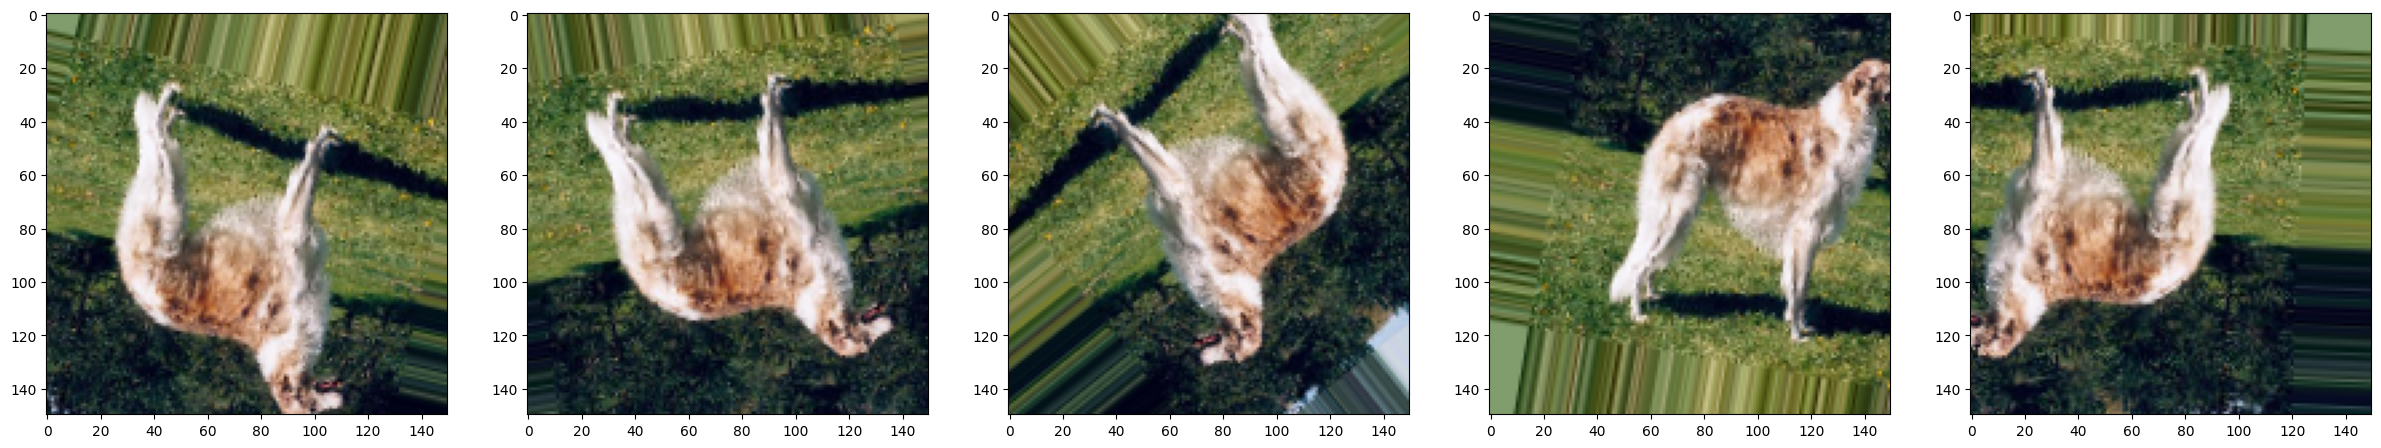

In [ ]:
train_datagen = ImageDataGenerator(
							rescale = 1./255,
							rotation_range = 40,
							width_shift_range = 0.2,
							height_shift_range = 0.2,
							shear_range = 0.3,
							horizontal_flip = True,
							vertical_flip = True,)

train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (150, 150),
							batch_size = 8,
							class_mode ='categorical',
							)

plt.figure()

f, axarr = plt.subplots(1, 5, figsize=(30, 8)) 

for i in range(5) :
  axarr[i].imshow(train_generator[0][0][0])

Definición de las capas del modelo

Para la versión dos del modelo también se utilizó VGG16.

In [ ]:
model = models.Sequential()

conv_base= VGG16(weights='imagenet',
								include_top = False,
								input_shape = (150,150,3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(3, activation='sigmoid'))

for layer in conv_base.layers[:-3]:
	conv_base.trainable = False 

for layer in conv_base.layers[-3:]:
	conv_base.trainable = True 
 
model.summary()

model.compile(loss='categorical_crossentropy',
						optimizer=optimizers.RMSprop(learning_rate=2e-5),
						metrics=['acc'])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_14 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 3)                 771       
                                                                 
Total params: 16,812,867
Trainable params: 16,812,867
Non-trainable params: 0
_________________________________________________________________


Entrenamiento del modelo

Epoch 1/40
113/113 [==============================] - 234s 2s/step - loss: 1.2093 - acc: 0.3667
Epoch 2/40
113/113 [==============================] - 13s 112ms/step - loss: 1.0762 - acc: 0.4389
Epoch 3/40
113/113 [==============================] - 13s 112ms/step - loss: 1.0323 - acc: 0.4444
Epoch 4/40
113/113 [==============================] - 12s 107ms/step - loss: 0.9741 - acc: 0.5133
Epoch 5/40
113/113 [==============================] - 13s 111ms/step - loss: 0.9316 - acc: 0.5489
Epoch 6/40
113/113 [==============================] - 13s 111ms/step - loss: 0.8831 - acc: 0.6011
Epoch 7/40
113/113 [==============================] - 13s 112ms/step - loss: 0.8385 - acc: 0.6256
Epoch 8/40
113/113 [==============================] - 13s 112ms/step - loss: 0.7410 - acc: 0.6633
Epoch 9/40
113/113 [==============================] - 13s 111ms/step - loss: 0.7091 - acc: 0.6989
Epoch 10/40
113/113 [==============================] - 13s 112ms/step - loss: 0.6606 - acc: 0.7100
Epoch 11/40
113/113 [

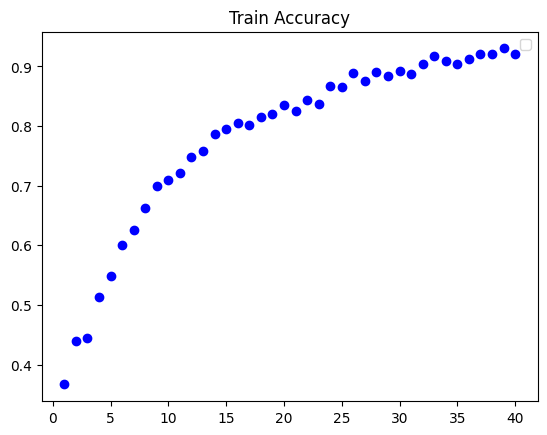

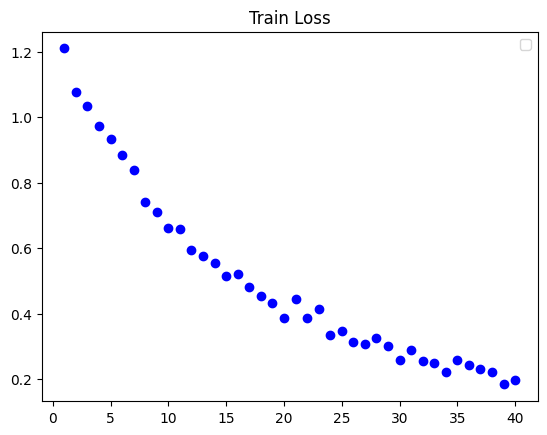

In [ ]:
history = model.fit(train_generator, epochs = 40)
				
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo')
plt.title('Train Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.title('Train Loss')
plt.legend()

plt.show()

Evaluación del modelo



In [ ]:
test_datagen = ImageDataGenerator(1./255)

test_generator = test_datagen.flow_from_directory(
					test_dir,
					target_size = (150, 150),
					batch_size = 8,
					class_mode= 'categorical')

test_loss, test_acc = model.evaluate(test_generator, steps = 40)

print('\nTest accuracy : ', test_acc)


Found 2100 images belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


40/40 [==============================] - 10s 248ms/step - loss: 82.1635 - acc: 0.5844

Test accuracy :  0.5843750238418579


263/263 [==============================] - 58s 221ms/step


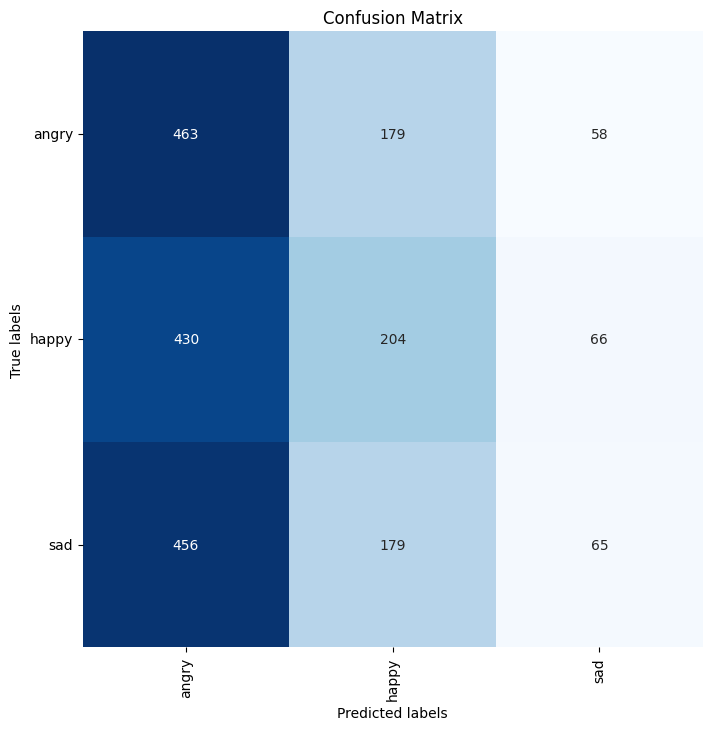

In [ ]:
# Get class labels
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Model predictions
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create figure
plt.figure(figsize=(8, 8))
ax = plt.gca()

# Create heatmap with seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)

# Add labels to axis
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.set_xticklabels(class_labels, rotation=90)
ax.set_yticklabels(class_labels, rotation=0)

# Show confusion matrix
plt.show()

Referencias

[1] Y. Mao and Y. Liu,"Pet dog facial expression recognition based on convolutional neural network and improved whale optimization algorithm". Springer Nature Scientific Reports. Feb. 2023. doi: 10.1038/s41598-023-30442-0